# Is winning a machine learning competition a complete crapshoot?

### TL;DR yes, if it's a small test set size like we often find in biomedical or biological problems.  And obviously the situation will be worse with large numbers of contest entrants

I was interested to read a [twitter discussion and blog post by Oakden-Rayner](https://lukeoakdenrayner.wordpress.com/2019/09/19/ai-competitions-dont-produce-useful-models/), that lead me to better understand something that every ML/datasci researcher has faced in their work: when the validation or test set is small, results may not accurately indicate the models performance on a new batch of samples.  What this post shows is that this phenomena gets worse in the context of a machine learning contest. When the performance difference between the winner and 2nd place in the contest is small, it is highly likely that the winner is actually no better than 2nd place.  A different test set sampled from the same population could very well have flipped the rankings of the entrants.  In other words, the winner is the one that just happens to overfit the given test set.  

Oakden-Raynor tackled the extent of this problem though good old statistical fashioned power calculations.  I decided to take a look at this phenomena through a Monte Carlo simulation. 

The ultimate null hypothesis for a machine learning competition is that every entrant actually has the same stochastic level of performance.  In this nightmare scenario every entrant to the contest has the same probability of accurate classification for every sample in the test set. Clearly by random chance one (or more) of the entrants will be better than the others, but how much better?  The more entrants there are in the contest, the more likely we will get a large over-permance from the tail of the distribution.  In this simulation, each test set response per entrant is a binomial random variable, with $n$ (the size of test set) and $p$ (prob of being correct) being identical for each entrant.  The binomial RVs for a given number of entrants $y$ are drawn 1000 times ($reps$, the number of times I run the simulated contest), and at the end I calculate the probability that any given contest would see a "winner" with a performance level much better than you would expect given $p$.  The chosen metric is classification error rate.

The results below show that under the assumptions of our null hypothesis, you can easily end up seeing a "winner" that has a surprisingly low error rate given the actual value of $p$.  Figure 1 shows the results expressed in terms of percent reduction from the expected error rate $(best-(1-p))/(1-p)$, and Figure 2 shows the same results expressed in terms of the raw delta $best-(1-p)$

Given the parameterization of the problem it is important to ask what typical values you might see in an ML contest for the number of test set samples and number of entrants.  Clearly the problematic area lies for large numbers of entrants in the contest with test set sizes < 10k.  Many competitions on Kaggle have thousands to tens of thousands of teams entering the competition. But most of those have millions of data points in the test set (based on me randomly clicking through stuff). Indeed, this [paper by Roelofs](https://arxiv.org/pdf/1411.2664.pdf) looks at the private vs public test set results of those bigger competitions and finds little evidence for overfitting.  

BUUUUTT...  Twitter and business operations data are cheap and plentiful. Medical and biological datasets tend to be expensive to collect. It's easy to get millions of records on house prices, harder on medical images or (my own research) RNAseq data.  For instance last year's RSNA Pneumonia Prediction contest had only 3000 images in the stage 2 test set, with 1500 teams entering the competition.  Figure 3 shows my simulations we would expect that there's no difference between 7th place and 1st place teams in terms of performance.  And to be honest it might be worse than that, since you might want to count the number of entrants as the number of models submitted and many teams submitted more than one model.  

I would bet a dollar that if Roelofs redid her analysis only on medical/biological dataset competitions the results might be different.  If I was less lazy/pressed for time in my real research I'd learn to use the Kaggle API like she did and figure it out myself.  After all, I've already wasted a bunch of time on this ;)



In [127]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

ps = []
ds = []
reps = 1000 # number of repetitions of the "competition"
for x in [0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.98]: # true prob of correct classification
    for y in [1,10,50,100,500,1000,5000]: # number of entrants in competition
        for z in [10,100,1000,10000,100000]: # number of samples in the test set
            draw = np.random.binomial(p=x,n=z,size=(y,reps)) # every entrant has the same probability of being correct for every element of the test set
            res = (z - draw.max(axis=0))/z # best error rate among entrants per rep
            eres = (1. - x) # expected error rate
            perc_change_from_expected = (res - eres) / eres * 100 - 100
            p10 = perc_change_from_expected[ perc_change_from_expected<=-10 ].shape[0] / reps # prob of getting at least one entrant w/ error rate 10% lower than true error rate
            p20 = perc_change_from_expected[ perc_change_from_expected<=-20 ].shape[0] / reps # 20%
            p30 = perc_change_from_expected[ perc_change_from_expected<=-30 ].shape[0] / reps # etc
            p40 = perc_change_from_expected[ perc_change_from_expected<=-40 ].shape[0] / reps
            p50 = perc_change_from_expected[ perc_change_from_expected<=-50 ].shape[0] / reps
            ps.append((x,y,z,p10,p20,p30,p40,p50))
                      
            delta = res - eres
            d005 = delta[ delta<=-0.005 ].shape[0] / reps # prob of getting at least one entrant w/ error rate 0.005 lower than true error rate
            d01 = delta[ delta<=-0.01 ].shape[0] / reps # prob of getting at least one entrant w/ error rate 0.01 lower than true error rate
            d02 = delta[ delta<=-0.02 ].shape[0] / reps 
            d04 = delta[ delta<=-0.04 ].shape[0] / reps
            d08 = delta[ delta<=-0.08 ].shape[0] / reps
            ds.append((x,y,z,d005,d01,d02,d04,d08))
                      
results = pd.DataFrame(data=ps,columns=['true prob','n_entrants','n_samples','10%','20%','30%','40%','50%'])
dresults = pd.DataFrame(data=ds,columns=['true prob','n_entrants','n_samples','delta<-0.005','delta<-0.01','delta<-0.02','delta<-0.04','delta<-0.08'])



mresults = results.melt(id_vars=['true prob','n_entrants','n_samples'],var_name='overperformance level',value_name='prob of overperformance')
mdresults = dresults.melt(id_vars=['true prob','n_entrants','n_samples'],var_name='overperformance level',value_name='prob of overperformance')



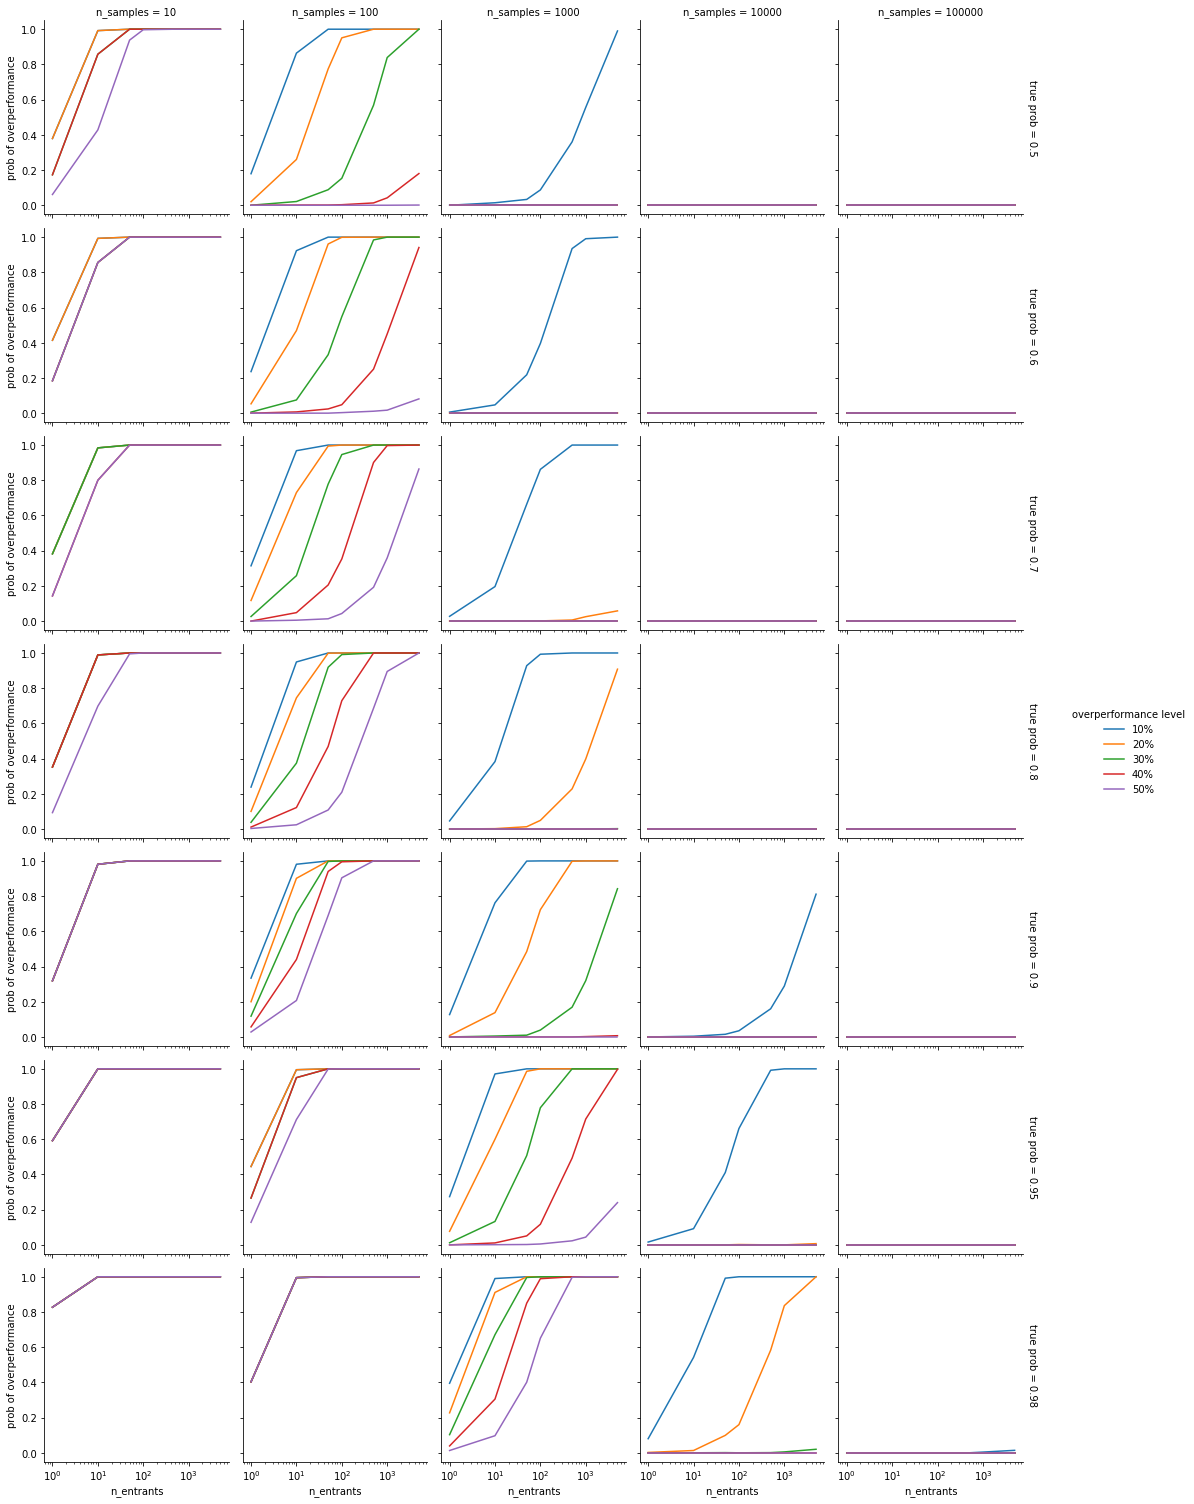

In [122]:
g = sns.FacetGrid(mresults,row='true prob',col='n_samples',hue='overperformance level',margin_titles=True)
g = (g.map(plt.semilogx, 'n_entrants', 'prob of overperformance').add_legend())


**Figure 1** The probability that a contest will see a "winner" that is X% percent better than the expected value of classification error rate $(best-(1-p))/(1-p)$.  Each graph shows the probability of the given level of over-performance (y-axis) among  against the number of entrants (x-axis) in a contest. Different colored curves show the results for different levels of over-performance (see legend).  Each row of the figure shows the graph for a different true probability of correct classification $p$; typical values that would represent state of the art algorithmic performance in benchmark machine learning problems would be somewhere in the 0.8 - 0.95 range. Each column of hte figure shows the results for a different test set size.  Once test set size is above 10,000 there is little chance of getting large overperformance by chance.  However there are many ML contests with test set size ~ 1k.  
  &nbsp;
  

&nbsp;
------
&nbsp;

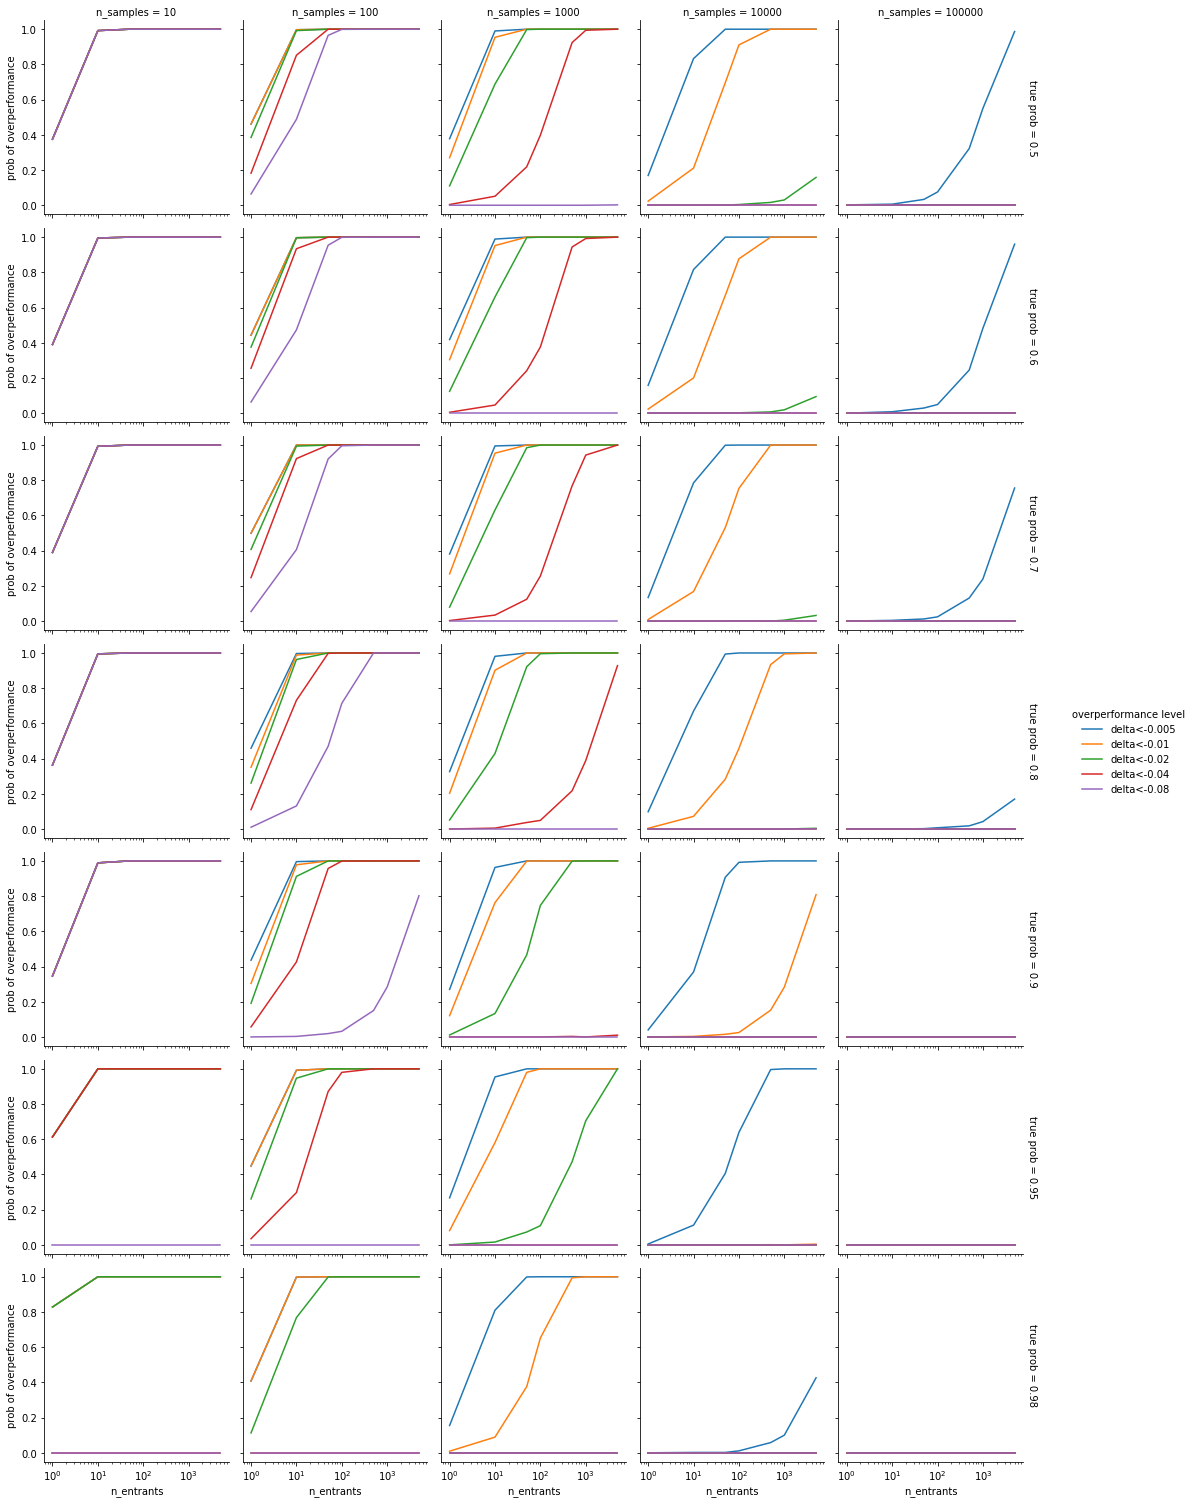

In [128]:
g = sns.FacetGrid(mdresults,row='true prob',col='n_samples',hue='overperformance level',margin_titles=True)
g = (g.map(plt.semilogx, 'n_entrants', 'prob of overperformance').add_legend())


**Figure 2** The probability that a contest will see a "winner" that is a given raw delta better than the expected value of classification error rate $(best-(1-p)$.  Each graph shows the probability of the given level of over-performance (y-axis) among  against the number of entrants (x-axis) in a contest. Different colored curves show the results for different levels of over-performance (see legend).  Each row of the figure shows the graph for a different true probability of correct classification $p$; typical values that would represent state of the art algorithmic performance in benchmark machine learning problems would be somewhere in the 0.8 - 0.95 range. Each column of hte figure shows the results for a different test set size.  Once test set size is above 10,000 there is little chance of getting large overperformance by chance.  However there are many ML contests with test set size ~ 1k.  
  &nbsp;
  

&nbsp;
------
&nbsp;

count    100.000000
mean       0.230873
std        0.000174
min        0.230246
25%        0.230772
50%        0.230850
75%        0.230992
max        0.231323
dtype: float64
the above roughly matches the Union / Intersection score of the 7th best team in the contest
let's take this as an indication that the true probability of correct classification: 1-.25(bit flip prob) = 0.75


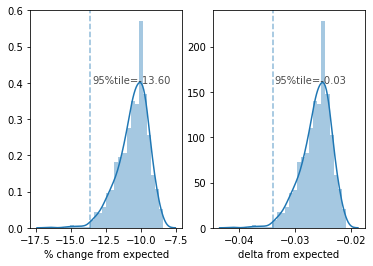

In [236]:
# looking at the images in https://arxiv.org/pdf/1811.08939.pdf it seems like 10% of the pixels are labeled pneumonia, and I'm totally guessing that there's about 10Mpixels in an image
proto = np.random.binomial(p=0.1,n=1,size=10000000) #10% of 10MPixels are pneumonia ground truth
rs = []
for x in range(100):
    test = proto ^ np.random.binomial(p=.25,n=1,size=10000000) # proto plus some bit flip noise
    rs.append( (proto&test).sum() / (proto | test).sum() )
print(pd.Series(rs).describe())
print('the above roughly matches the Union / Intersection score of the 7th best team in the contest')
print('let\'s take this as an indication that the true probability of correct classification: 1-.25(bit flip prob) = 0.75')


y=1500  # n_entrants for RSNA PP
x=0.75    # prob of correct prediction from above
z=3000 # n_samples for stage II test of RSNA PP

draw = np.random.binomial(p=x,n=z,size=(y,reps)) # every entrant has the same probability of being correct for every element of the test set
res = (z - draw.max(axis=0))/z # best error rate among entrants per rep
eres = (1. - x) # expected error rate
perc_change_from_expected = (res - eres) / eres * 100
ax = plt.subplot(1,2,1)
sns.distplot( perc_change_from_expected, ax=ax )
cut95 =  np.percentile( perc_change_from_expected, 0.95) 
ax.axvline(x=cut95, linestyle='dashed', alpha=0.5)
ax.text(x=cut95*.99, y=.4, s='95%tile={:3.2f}'.format(cut95), alpha=0.7)
plt.xlabel('% change from expected')
ax = plt.subplot(1,2,2)
delta = res - eres
plt.xlabel('delta from expected')
sns.distplot( delta,  ax=ax, norm_hist=True);
cut95 =  np.percentile( delta, 0.95) 
ax.axvline(x=cut95, linestyle='dashed', alpha=0.5)
ax.text(x=cut95*.99, y=160, s='95%tile={:3.2f}'.format(cut95), alpha=0.7);



In [235]:
print('the 95%tile of our null model implies that we could subtract up to 0.03 from the error rate of a team doing about 7th place performance level to find the performance level of our random "winner"')
proto = np.random.binomial(p=0.1,n=1,size=10000000) #10% of 10MPixels are pneumonia ground truth
rs = []
for x in range(100):
    test = proto ^ np.random.binomial(p=.22,n=1,size=10000000) # bit flip noise is now 0.03 less than the expected value 
    rs.append( (proto&test).sum() / (proto | test).sum() )
print(pd.Series(rs).describe())
print('the above is better than the Union / Intersection score of the best team in the contest (0.254)')



the 95%tile of our null model implies that we could subtract up to 0.03 from the error rate of a team doing about 7th place performance level to find the performance level of our random "winner"
count    100.000000
mean       0.261986
std        0.000178
min        0.261608
25%        0.261860
50%        0.261986
75%        0.262111
max        0.262490
dtype: float64
the above is better than the Union / Intersection score of the best team in the contest (0.254)


**Figure 3**  The distributions of how much better than expected the "winners" will perform in 1000 draws of the null model using $n_{entrants}, p, n_{samples}$ values consistent with the 2018 RSNA Pnuemonia diagnosis contest from Kaggle.   Because the contest used a performance metric of Area of Union / Area of Intersection for the labelled pneumonia pixels vs the ground truth labelled pixels I had to play some games to turn this into a pixel-wise misclassification rate, but you can follod the logic in my hand-tuning above.  TL;DR the 7th place team and the 1st place team are interchangable according to my null hypothesis.    
  &nbsp;
  